0) Colab 구글계정 생성

1) 구글드라이브 -> 내 드라이브 ->  Colab Notebooks 폴더 -> eTL 업로드 된 폴더 "IAB_Challenge" 업로드


2) "IAB_Challenge" 폴더 내 "IAB_Challenge_Skeleton.ipynb" 실행


3-1) 파일명 수정 -> "학번_이름.ipynb" ex) 202012345_GilDongHong.ipynb

3-2) 맨 첫 줄 ID 수정 -> "학번_이름" ex) ID = "202012345_GilDongHong"


4) 모델 학습 완료 후,  model_학번_이름.pth, 학번_이름.ipynb 두 파일을 압축한 202012345_GilDongHong.zip 파일을 eTL에 제출


In [ ]:
ID = "h"
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import torch
import patoolib
import numpy as np
import torch.nn as nn
import torchvision
import torch.optim as optim
from google.colab import drive
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as transforms

drive.mount('/content/drive')
CHLNG_PATH = "/content/drive/MyDrive/Colab Notebooks/IAB_Challenge/"
TRAIN_DIR = "event_img/event_img_train"
VAL_DIR = "event_img/event_img_val"
MODEL_PATH = os.path.join(CHLNG_PATH, f"model_{ID}.pth")
print(os.path.abspath(os.path.curdir))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [ ]:
try:
  patoolib.extract_archive(os.path.join(CHLNG_PATH, "event_img.zip"), outdir=CHLNG_PATH)
except:
  print(f"Already extracted")

patool: Extracting /content/drive/MyDrive/Colab Notebooks/IAB_Challenge/event_img.zip ...
patool: running /usr/bin/7z x "-o/content/drive/MyDrive/Colab Notebooks/IAB_Challenge/" -- "/content/drive/MyDrive/Colab Notebooks/IAB_Challenge/event_img.zip"
Already extracted


In [ ]:
class SportsDataset(Dataset):
  def __init__(self, img_dir, transform=None):
    self.img_dir = img_dir
    self.classes = []
    self.img_path = []

    for class_ in os.listdir(self.img_dir):
      if '.' in class_:
        continue
      self.classes.append(class_)
      for img_ in os.listdir(os.path.join(self.img_dir, class_)):
        if img_[-3:] != 'jpg':
          continue
        self.img_path.append(os.path.join(self.img_dir, class_, img_))

    self.num_samples = len(self.img_path)
    self.transform = transform
    self.class_to_label = {k: v for k, v in zip(self.classes, range(len(self.classes)))}

  def __len__(self):
    return self.num_samples

  def __getitem__(self, idx):
    image = read_image(self.img_path[idx])
    if self.transform:
      image = self.transform(image.type(torch.float))

    label = self.class_to_label[str(self.img_path[idx]).split('/')[-2]]
    return image, label

channel_means = [119.1102, 123.3985, 114.8211]
channel_stds = [61.8950, 60.7454, 67.1402]

train_transform = transforms.Compose([
        transforms.Resize(size=(224, 224), antialias=True),
        transforms.Normalize(channel_means, channel_stds)
])

batch_size = 32
trainset = SportsDataset(img_dir=os.path.join(CHLNG_PATH, TRAIN_DIR), transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
classes = trainset.classes

test_channel_means = [119.2347, 122.6966, 118.3286]
test_stds = [62.6977, 61.2758, 67.4875]

test_transform = transforms.Compose([
          transforms.Resize(size=(224, 224), antialias=True),
          transforms.Normalize(test_channel_means, test_stds)
])

testset = SportsDataset(img_dir=os.path.join(CHLNG_PATH, VAL_DIR), transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset.class_to_label = trainset.class_to_label

print(f"The number of train samples: {trainset.num_samples}")
print(f"256th img path: {trainset.img_path[256]}")
print(f"Its normalized values: {trainset[256]}\nShape: {trainset[256][0].shape}")
print(f"Label name to the index mapping: {trainset.class_to_label}")

The number of train samples: 1264
256th img path: /content/drive/MyDrive/Colab Notebooks/IAB_Challenge/event_img/event_img_train/bocce/Medium_Mid_bocce_7.jpg
Its normalized values: (tensor([[[-1.4221, -1.5094, -1.5251,  ..., -1.1434, -1.0397, -1.0094],
         [-1.4496, -1.5188, -1.5060,  ..., -1.1459, -1.0555, -1.0225],
         [-1.4266, -1.4908, -1.5327,  ..., -1.1429, -1.0873, -1.0564],
         ...,
         [-0.1259, -0.2195,  0.0418,  ...,  0.3989,  0.3162,  0.4110],
         [ 0.0826, -0.0614, -0.0146,  ...,  0.6167,  0.5552,  0.4963],
         [ 0.0401,  0.0311, -0.0318,  ...,  0.4207,  0.6215,  0.5930]],

        [[-1.3550, -1.4472, -1.5232,  ..., -1.2972, -1.2339, -1.1640],
         [-1.4710, -1.5372, -1.5405,  ..., -1.3024, -1.2161, -1.1770],
         [-1.4650, -1.5555, -1.5924,  ..., -1.2863, -1.2400, -1.2115],
         ...,
         [-0.2496, -0.3707, -0.0438,  ...,  0.3340,  0.2987,  0.3766],
         [ 0.0959, -0.0700, -0.0802,  ...,  0.5960,  0.6409,  0.4783],
       

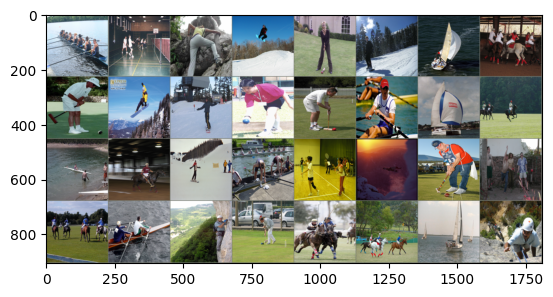

rowing          badminton       RockClimbing    snowboarding    croquet         snowboarding    sailing         polo           
croquet         snowboarding    snowboarding    bocce           croquet         rowing          sailing         polo           
rowing          polo            snowboarding    rowing          badminton       snowboarding    croquet         bocce          
polo            rowing          RockClimbing    croquet         polo            polo            sailing         RockClimbing   


In [ ]:
def imshow(img):
    img = (img * torch.Tensor(channel_stds).view(-1, 1, 1)) + torch.Tensor(channel_means).view(-1, 1, 1)  # un-normalize
    npimg = img.type(torch.uint8).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 8
imshow(torchvision.utils.make_grid(images, nrow=nrow))

# print labels
for i in range(int(batch_size/nrow)):
  print(' '.join(f'{classes[labels[i*nrow + j]]:15s}' for j in range(nrow)))

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            #3 224 128
            nn.Conv2d(3, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #64 112 64
            nn.Conv2d(64, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #128 56 32
            nn.Conv2d(128, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #256 28 16
            nn.Conv2d(256, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            #512 14 8
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 3, padding=1),nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
        #512 7 4

        self.avg_pool = nn.AvgPool2d(7)
        #512 1 1
        self.classifier = nn.Linear(512, 1000)
        """
        self.fc1 = nn.Linear(512*2*2,4096)
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,10)
        """

    def forward(self, x):
        #print(x.size())
        features = self.conv(x)
        #print(features.size())
        x = self.avg_pool(features)
        #print(avg_pool.size())
        x = x.view(features.size(0), -1)
        #print(flatten.size())
        x = self.classifier(x)
        #x = self.softmax(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
print(device)

cuda


In [ ]:
def chk_acc(type_: str, dataloader):
  net.eval()
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for idx, data in enumerate(dataloader):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

  print(f'Accuracy of the network on the {total} {type_} images: {100 * correct // total} %')
  net.train()
  return 100 * correct // total

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=7*1e-5, weight_decay=1e-4)

print_interval = 10
num_epoch = 20
best_acc = 0
for epoch in range(num_epoch):  # loop over the dataset multiple times
    t_ = time.time()

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_interval == print_interval-1:    # print every print_interval mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_interval:.3f} e_t: {(time.time() - t_):.2f}s')
            running_loss = 0.0
            t_ = time.time()
    chk_acc(type_="train", dataloader=trainloader)
    cur_acc = chk_acc(type_="test", dataloader=testloader)

    # save the best model
    if best_acc < cur_acc:
      best_acc = cur_acc
      torch.save(net.state_dict(), MODEL_PATH)

print('Finished Training')

[1,    10] loss: 2.424 e_t: 9.13s
[1,    20] loss: 1.865 e_t: 8.34s
[1,    30] loss: 1.609 e_t: 7.84s
[1,    40] loss: 1.603 e_t: 7.32s
Accuracy of the network on the 1264 train images: 31 %
Accuracy of the network on the 154 test images: 28 %
[2,    10] loss: 1.695 e_t: 9.55s
[2,    20] loss: 1.587 e_t: 8.04s
[2,    30] loss: 1.599 e_t: 7.95s
[2,    40] loss: 1.525 e_t: 8.23s
Accuracy of the network on the 1264 train images: 38 %
Accuracy of the network on the 154 test images: 37 %
[3,    10] loss: 1.511 e_t: 9.74s
[3,    20] loss: 1.509 e_t: 6.89s
[3,    30] loss: 1.601 e_t: 8.91s
[3,    40] loss: 1.608 e_t: 6.41s
Accuracy of the network on the 1264 train images: 33 %
Accuracy of the network on the 154 test images: 33 %
[4,    10] loss: 1.515 e_t: 8.55s
[4,    20] loss: 1.442 e_t: 8.57s
[4,    30] loss: 1.603 e_t: 6.37s
[4,    40] loss: 1.495 e_t: 8.51s
Accuracy of the network on the 1264 train images: 43 %
Accuracy of the network on the 154 test images: 42 %
[5,    10] loss: 1.418 e

In [ ]:
net.load_state_dict(torch.load(MODEL_PATH))
chk_acc(type_="test", dataloader=testloader)

Accuracy of the network on the 154 test images: 63 %


63

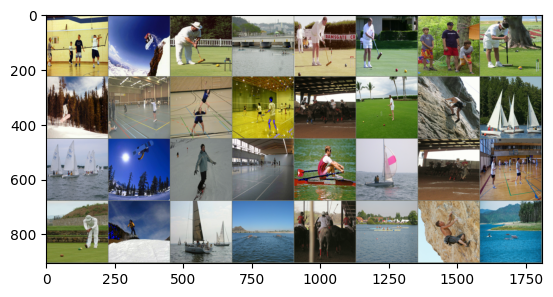

GroundTruth: 
badminton       snowboarding    croquet         rowing          croquet         croquet         bocce           croquet        
snowboarding    badminton       badminton       badminton       polo            croquet         RockClimbing    sailing        
sailing         snowboarding    snowboarding    badminton       rowing          sailing         polo            badminton      
croquet         snowboarding    sailing         rowing          polo            rowing          RockClimbing    rowing         

Predicted: 
badminton       snowboarding    croquet         snowboarding    polo            croquet         croquet         croquet        
RockClimbing    badminton       badminton       badminton       bocce           croquet         RockClimbing    badminton      
sailing         snowboarding    sailing         rowing          polo            sailing         bocce           badminton      
croquet         snowboarding    sailing         snowboarding    polo         

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images, nrow=nrow))
print('GroundTruth: ')
for i in range(int(batch_size/nrow)):
  print(' '.join(f'{classes[labels[i*nrow + j]]:15s}' for j in range(nrow)))

outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('\nPredicted: ')
for i in range(int(batch_size/nrow)):
  print(' '.join(f'{classes[predicted[i*nrow + j]]:15s}' for j in range(nrow)))

In [ ]:
# prepare to count predictions for each test_classes
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each classes
        for label, prediction in zip(labels.to(device), predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: badminton is 83.3 %
Accuracy for class: bocce is 30.8 %
Accuracy for class: croquet is 73.9 %
Accuracy for class: polo  is 44.4 %
Accuracy for class: RockClimbing is 63.2 %
Accuracy for class: rowing is 44.0 %
Accuracy for class: sailing is 94.7 %
Accuracy for class: snowboarding is 68.4 %


In [ ]:
""" DO NOT RUN THIS CELL!

TEST_DIR = "event_img/event_img_test"  # Do not use this
testset = SportsDataset(img_dir=os.path.join(CHLNG_PATH, TEST_DIR), transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testset.class_to_label = trainset.class_to_label
net.load_state_dict(torch.load(MODEL_PATH))
chk_acc(type_="test", dataloader=testloader)
"""